# Imports

In [133]:
import geopandas as gpd
from shapely.geometry.point import Point
from operator import itemgetter
import numpy as np
from tqdm import tqdm
import geopandas as gpd
from shapely.geometry import Polygon
import pandas as pd
from pcse.db import NASAPowerWeatherDataProvider
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Function definitions

# Training local model

## NASA Power data collection and formatting

<AxesSubplot:>

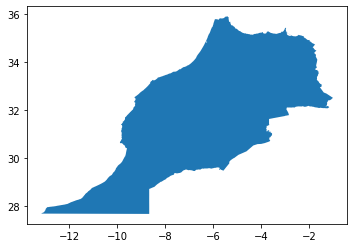

In [2]:
#country limit source https://www.diva-gis.org/datadown
map = gpd.read_file("../../data/LMI_trema/MAR_adm0.shp")
map.plot()

In [6]:
bounds = map.geometry.apply(lambda x: x.bounds).tolist()
minlong, minlat, maxlong, maxlat = min(bounds, key=itemgetter(0))[0], min(bounds, key=itemgetter(1))[1], max(bounds, key=itemgetter(2))[2], max(bounds, key=itemgetter(3))[3]
minlong, minlat, maxlong, maxlat 

(-13.167915344238281,
 27.670074462890852,
 -0.997406005859375,
 35.92263793945318)

In [9]:
resolution = 0.5
minlong_round = np.round(minlong/resolution)*resolution - resolution/2
minlat_round = np.round(minlat/resolution)*resolution - resolution/2
maxlong_round = np.round(maxlong/resolution)*resolution + resolution/2
maxlat_round = np.round(maxlat/resolution)*resolution + resolution/2

In [16]:
weather_country = pd.DataFrame()
polygon = gpd.GeoDataFrame()
crs = {'init': 'epsg:4326'}

for lat in tqdm(np.arange(minlat_round, maxlat_round, resolution)):
    for long in np.arange(minlong_round, maxlong_round, resolution):
        condition = (map.contains(Point(long+resolution/2,lat+resolution/2)).values[0]) | (map.contains(Point(long-resolution/2,lat-resolution/2)).values[0]) | (map.contains(Point(long-resolution/2,lat+resolution/2)).values[0]) | (map.contains(Point(long+resolution/2,lat-resolution/2)).values[0])
        if condition : 

            weatherdata = NASAPowerWeatherDataProvider(lat,long)
            weather_df = pd.DataFrame(weatherdata.export())
            weather_df["ET0"]=weather_df["ET0"] * 10 # conversion données NASA Power cm to mm
            weather_country = weather_country.append(weather_df)


            # construction du geodataframe pour la carte chloroplethe
            lat_point_list = [lat+resolution/2, lat+resolution/2, lat-resolution/2, lat-resolution/2]
            lon_point_list = [long+resolution/2, long-resolution/2, long-resolution/2, long+resolution/2]
            polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
            
            polygon = polygon.append(gpd.GeoDataFrame({"lat":lat, "long":long}, index=[0], crs=crs, geometry=[polygon_geom]))
            

100%|██████████| 18/18 [08:59<00:00, 29.97s/it]


In [69]:
mymap = folium.Map(tiles='openstreetmap', control_scale=True, location=(np.mean([minlat,maxlat]), np.mean([minlong,maxlong])), zoom_start=6)
polygon.explore(m=mymap)

In [70]:
polygon

,lat,long,geometry
0,27.75,-12.75,"POLYGON ((-12.50000 28.00000, -13.00000 28.000..."
0,27.75,-12.25,"POLYGON ((-12.00000 28.00000, -12.50000 28.000..."
0,27.75,-11.75,"POLYGON ((-11.50000 28.00000, -12.00000 28.000..."
0,27.75,-11.25,"POLYGON ((-11.00000 28.00000, -11.50000 28.000..."
0,27.75,-10.75,"POLYGON ((-10.50000 28.00000, -11.00000 28.000..."
...,...,...,...
0,35.25,-2.75,"POLYGON ((-2.50000 35.50000, -3.00000 35.50000..."
0,35.25,-2.25,"POLYGON ((-2.00000 35.50000, -2.50000 35.50000..."
0,35.75,-6.25,"POLYGON ((-6.00000 36.00000, -6.50000 36.00000..."
0,35.75,-5.75,"POLYGON ((-5.50000 36.00000, -6.00000 36.00000..."


In [71]:
weather_country

,LAT,LON,ELEV,IRRAD,TMIN,TMAX,VAP,RAIN,E0,ES0,ET0,WIND,TEMP,DAY
0,27.75,-12.75,25.70,11200000.0,11.98,21.08,11.994577,0.000,0.279378,0.250045,2.799675,3.09,16.17,1984-01-01
1,27.75,-12.75,25.70,11580000.0,11.58,22.02,10.941424,0.000,0.315114,0.284622,3.332261,3.43,16.56,1984-01-02
2,27.75,-12.75,25.70,10310000.0,14.01,21.97,9.814065,0.000,0.401175,0.373398,4.234532,4.31,17.30,1984-01-03
3,27.75,-12.75,25.70,10360000.0,14.51,20.21,13.951822,0.000,0.330217,0.302638,2.970101,5.32,17.06,1984-01-04
4,27.75,-12.75,25.70,11030000.0,15.33,18.95,12.680231,0.000,0.424767,0.395529,3.669563,7.26,17.28,1984-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13991,35.75,-5.25,38.08,24770000.0,14.80,17.70,14.571144,0.015,0.479403,0.414859,3.663086,2.27,16.30,2022-04-24
13992,35.75,-5.25,38.08,24810000.0,14.37,17.30,15.344090,0.001,0.460427,0.396323,3.456317,1.94,15.94,2022-04-25
13993,35.75,-5.25,38.08,12640000.0,15.12,16.19,14.782881,0.677,0.323345,0.290808,2.319102,3.42,15.48,2022-04-26
13994,35.75,-5.25,38.08,21740000.0,15.33,18.33,15.194620,0.035,0.430552,0.373243,3.402617,1.30,16.67,2022-04-27


In [153]:
import datetime

basetemp = 0
aim_date = datetime.date(2021,10,31)
year=2021
aim_tempsum = 1000

ok_coords = polygon[["lat","long"]].drop_duplicates().reset_index(drop=True)
weather_country_year = weather_country[weather_country.apply(lambda x: x["DAY"].year, axis=1)==year]

for i in tqdm(range(len(ok_coords))) :

        lat = ok_coords.loc[i,"lat"]
        long = ok_coords.loc[i,"long"]
        
        weather_country_year_tile = weather_country_year[(weather_country_year["LAT"]==lat) & (weather_country_year["LON"]==long)]
        weather_country_year_tile = weather_country_year_tile[weather_country_year_tile["DAY"]<=aim_date]       
        weather_country_year_tile = weather_country_year_tile.sort_values(by="DAY", ascending=False).reset_index(drop=True)
        weather_country_year_tile["TEMP_minus_base"] = weather_country_year_tile["TEMP"]-basetemp
        weather_country_year_tile["TEMP_sum"] = np.cumsum(weather_country_year_tile["TEMP_minus_base"])
        date_occuring = weather_country_year_tile.loc[weather_country_year_tile["TEMP_sum"]>aim_tempsum,"DAY"].values[0]
        #print("La date à laquelle la somme de températures %s sera atteinte est le %s" % (aim_tempsum,date_occuring))
        polygon.loc[(polygon["lat"]==lat) & (polygon["long"]==long),"date_occuring"] = date_occuring

100%|██████████| 194/194 [00:02<00:00, 80.50it/s]


In [154]:
polygon["date_occuring_julian"] = polygon.apply(lambda x: (x["date_occuring"] - datetime.date(year,1,1)).days, axis=1)
polygon["date_occuring_week"] = polygon["date_occuring_julian"]/7

# Cartes

In [155]:
print("Saison %s - Carte de la date de semis au plus tard (en numéro de semaine) pour atteindre le %s une somme de température de %s °C.j avec une température de base de %s°C" % (year, aim_date, aim_tempsum, basetemp))

Saison 2021 - Carte de la date de semis au plus tard (en numéro de semaine) pour atteindre le 2021-10-31 une somme de température de 1000 °C.j avec une température de base de 0°C


In [156]:
mymap = folium.Map(tiles='OpenStreetMap', control_scale=True, location=(np.mean([minlat,maxlat]), np.mean([minlong,maxlong])), zoom_start=6, legend_name="hello")
polygon[["lat","long","geometry","date_occuring_week"]].explore(m=mymap, column='date_occuring_week', style_kwds=dict(color="black", opacity=0, fillOpacity=0.5))

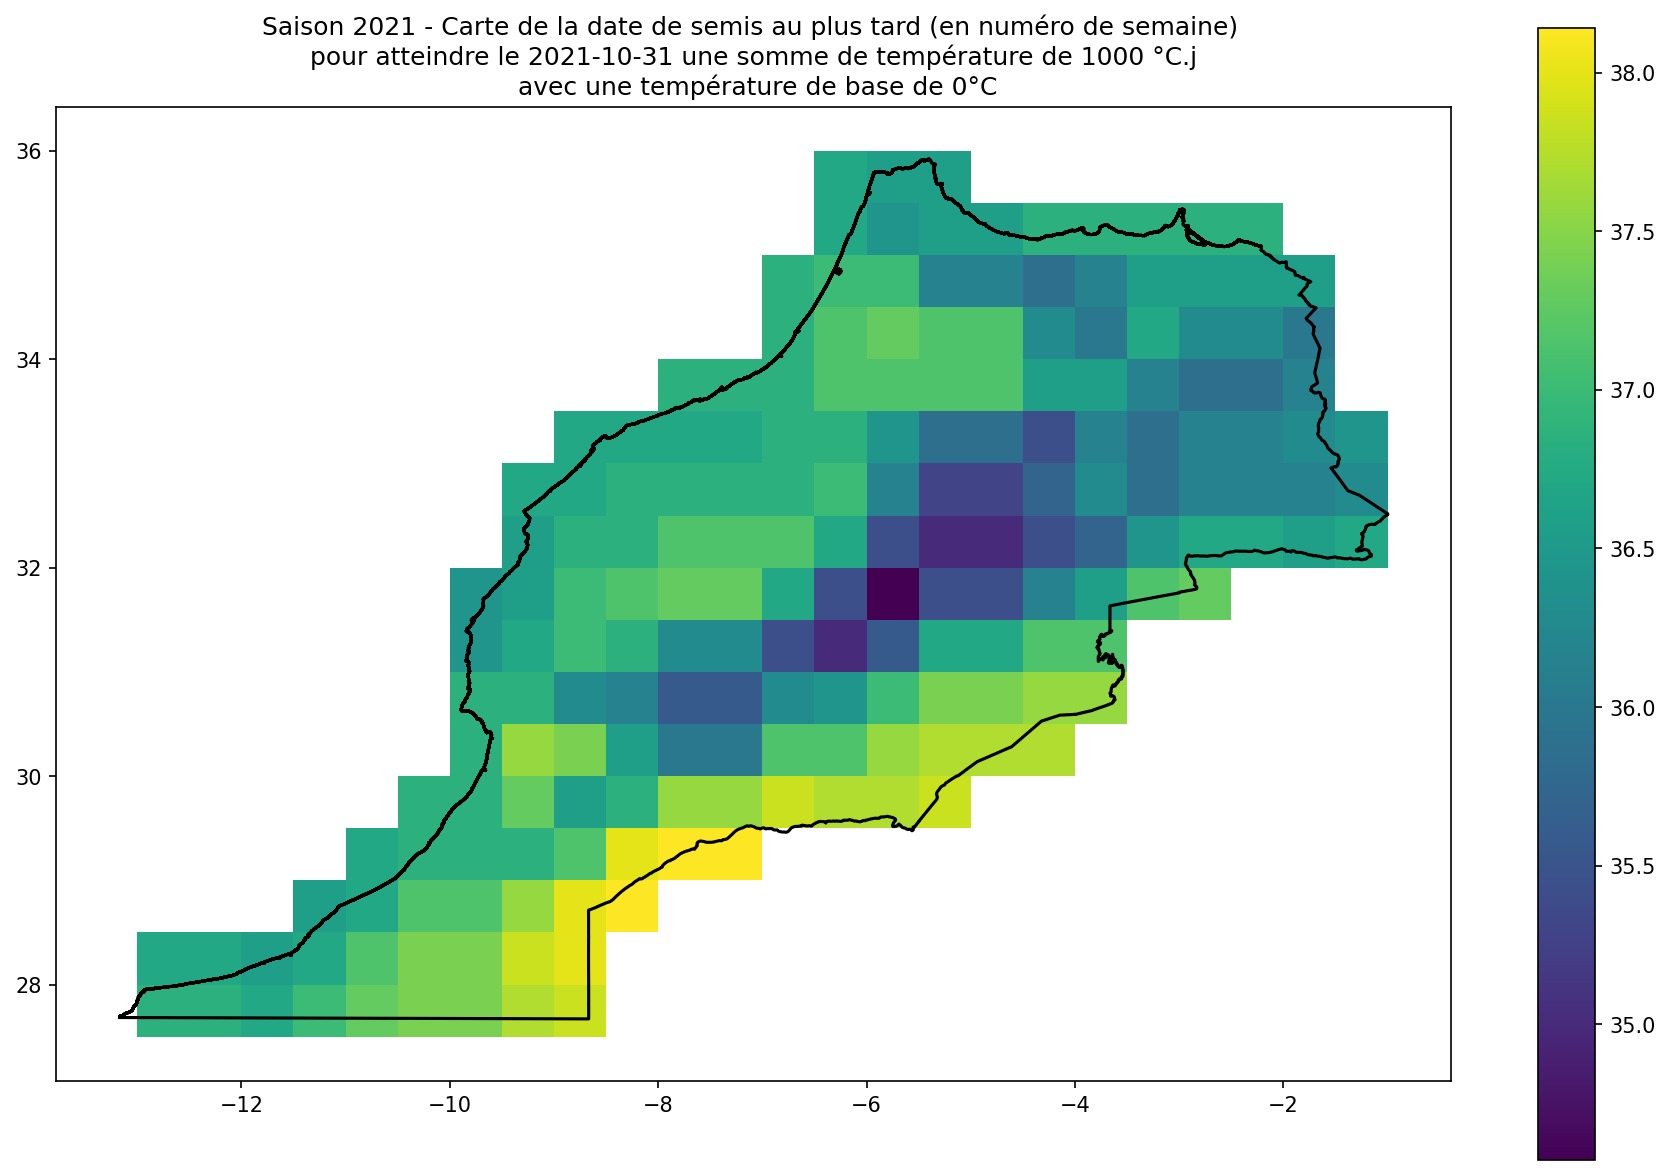

In [157]:
map = gpd.read_file("../../data/LMI_trema/MAR_adm0.shp")

fig, ax = plt.subplots(1, 1, figsize=(15, 10), dpi=150)
polygon.plot(ax=ax, column="date_occuring_week", legend=True)
map.boundary.plot(ax=ax, color="black")
plt.title("Saison %s - Carte de la date de semis au plus tard (en numéro de semaine) \n pour atteindre le %s une somme de température de %s °C.j \n avec une température de base de %s°C" % (year, aim_date, aim_tempsum, basetemp))
plt.show()